In [1]:
from google.colab import files
!pip install -q kaggle

In [2]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [4]:
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.16G/1.17G [00:07<00:00, 149MB/s]
100% 1.17G/1.17G [00:07<00:00, 160MB/s]


In [5]:
! unzip /content/100-bird-species.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/TURQUOISE MOTMOT/043.jpg  
  inflating: train/TURQUOISE MOTMOT/044.jpg  
  inflating: train/TURQUOISE MOTMOT/045.jpg  
  inflating: train/TURQUOISE MOTMOT/046.jpg  
  inflating: train/TURQUOISE MOTMOT/047.jpg  
  inflating: train/TURQUOISE MOTMOT/048.jpg  
  inflating: train/TURQUOISE MOTMOT/049.jpg  
  inflating: train/TURQUOISE MOTMOT/050.jpg  
  inflating: train/TURQUOISE MOTMOT/051.jpg  
  inflating: train/TURQUOISE MOTMOT/052.jpg  
  inflating: train/TURQUOISE MOTMOT/053.jpg  
  inflating: train/TURQUOISE MOTMOT/054.jpg  
  inflating: train/TURQUOISE MOTMOT/055.jpg  
  inflating: train/TURQUOISE MOTMOT/056.jpg  
  inflating: train/TURQUOISE MOTMOT/057.jpg  
  inflating: train/TURQUOISE MOTMOT/058.jpg  
  inflating: train/TURQUOISE MOTMOT/059.jpg  
  inflating: train/TURQUOISE MOTMOT/060.jpg  
  inflating: train/TURQUOISE MOTMOT/061.jpg  
  inflating: train/TURQUOISE MOTMOT/062.jpg  
  inflating: train/TURQUOISE 

In [6]:
import numpy as np
import pandas as pd
import glob
import random 
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import seaborn as sns
from sklearn import metrics

In [7]:
files = glob.glob('/content/valid/*')

In [8]:
species = [fname.split("/")[-1] for fname in files]
species[0:5] + ["..."]

['ROADRUNNER',
 'NORTHERN FLICKER',
 'EASTERN BLUEBIRD',
 'SPOTTED CATBIRD',
 'DOUBLE BARRED FINCH',
 '...']

In [9]:
datasets = ["train", "test", "valid"]

In [10]:
im_width = round(224/4)
im_height = round(224/4)
print("Image new width: " + str(im_width))
print("Image new height: " + str(im_height))

Image new width: 56
Image new height: 56


In [11]:
%%time

data = dict({"train": [], "test": [], "valid": []})
target = dict({"train": [], "test": [], "valid": []})

for set_ in datasets:
    for spec in species:
        filelist = glob.glob('/content/' + set_ + '/' + spec + '/*.jpg')
        target[set_].extend([spec for _ in filelist])
        data[set_].extend([np.array(Image.open(fname).resize((im_width, im_height))) for fname in filelist])
    data[set_] = np.stack(data[set_], axis=0)

CPU times: user 1min 17s, sys: 2.39 s, total: 1min 20s
Wall time: 1min 19s


In [12]:
print("train set shape: " + str(data["train"].shape))
print("test set shape: " + str(data["test"].shape))
print("validation set shape: " + str(data["valid"].shape))

train set shape: (47332, 56, 56, 3)
test set shape: (1625, 56, 56, 3)
validation set shape: (1625, 56, 56, 3)


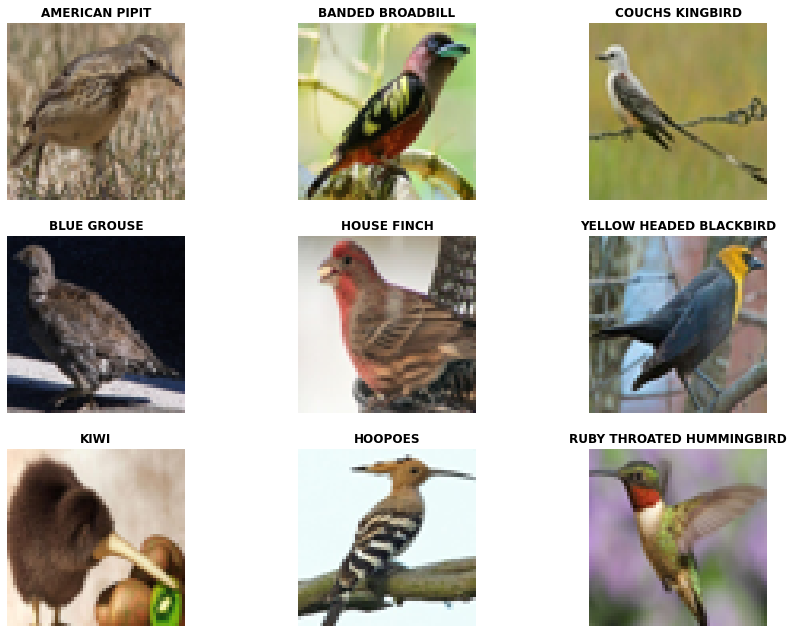

In [13]:
fig = plt.figure(figsize=(20,15))
grid = fig.add_gridspec(4, 4)

for row in range(0, 3):
    for col in range(0, 3):
        num_image = random.randint(0, data["train"].shape[0])
        ax = fig.add_subplot(grid[row, col])
        ax.axis('off');
        ax.set_title(target["train"][num_image], fontdict={"fontweight": 700})
        ax.imshow(data["train"][num_image]);

In [13]:
data_normal = data.copy()

In [14]:
data_normal["train"] = np.round((data_normal["train"]/255), 3)
data_normal["test"] = np.round((data_normal["test"]/255), 3)
data_normal["valid"] = np.round((data_normal["valid"]/255), 3)

In [15]:
encoder = LabelEncoder().fit(target["train"])

In [16]:
target_category = target.copy()

In [17]:
target_category["train"] = encoder.transform(target_category["train"])
target_category["test"] = encoder.transform(target_category["test"])
target_category["valid"] = encoder.transform(target_category["valid"])

In [18]:
target_onehot = target_category.copy()

In [19]:
target_onehot["train"] = to_categorical(target_onehot["train"])
target_onehot["test"] = to_categorical(target_onehot["test"])
target_onehot["valid"] = to_categorical(target_onehot["valid"])

In [21]:
def initial_model(name):
    model = Sequential(name=name)
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(im_height, im_width, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(325, activation='softmax'))

    return model

In [22]:
model1 = initial_model(name="Initial")
model1.summary()

Model: "Initial"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                           

In [23]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics="accuracy")
    return model

Epoch 1/50
2959/2959 [==============================] - 25s 5ms/step - loss: 4.7895 - accuracy: 0.0709 - val_loss: 3.8786 - val_accuracy: 0.1686 - lr: 0.0010
Epoch 2/50
2959/2959 [==============================] - 15s 5ms/step - loss: 3.5152 - accuracy: 0.2227 - val_loss: 2.5093 - val_accuracy: 0.3951 - lr: 0.0010
Epoch 3/50
2959/2959 [==============================] - 15s 5ms/step - loss: 2.8773 - accuracy: 0.3359 - val_loss: 2.1859 - val_accuracy: 0.4745 - lr: 0.0010
Epoch 4/50
2959/2959 [==============================] - 16s 5ms/step - loss: 2.4855 - accuracy: 0.4037 - val_loss: 1.9147 - val_accuracy: 0.5163 - lr: 0.0010
Epoch 5/50
2959/2959 [==============================] - 16s 5ms/step - loss: 2.1932 - accuracy: 0.4616 - val_loss: 1.7436 - val_accuracy: 0.5643 - lr: 0.0010
Epoch 6/50
2959/2959 [==============================] - 15s 5ms/step - loss: 1.9594 - accuracy: 0.5061 - val_loss: 1.5117 - val_accuracy: 0.5957 - lr: 0.0010
Epoch 7/50
2956/2959 [============================>.

[1.147972822189331, 0.7181538343429565]

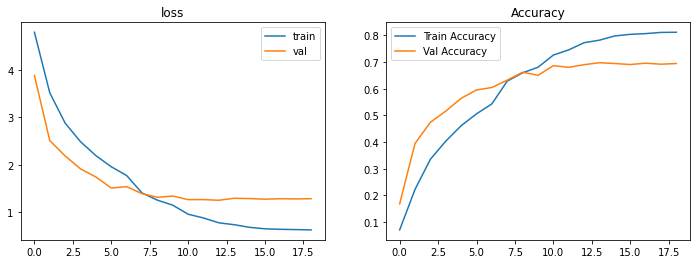

In [24]:
model_initial = initial_model(name="Initial")
model_initial = compile_model(model_initial)

callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

history_initial = model_initial.fit(data_normal["train"], target_onehot["train"],
                                      batch_size=16,
                                      epochs=50,
                                      validation_data=(data_normal["valid"], target_onehot["valid"]),
                                      callbacks=callback)

def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Train Accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy'  + exp_name)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(history_initial, title='', axs=None, exp_name="");

model_initial.evaluate(data_normal["test"], target_onehot["test"], verbose=0)

In [22]:
y_pred = [np.argmax(val) for val in list(model_initial.predict(data_normal["test"]))]
y_true = target_category["test"].copy()

NameError: ignored

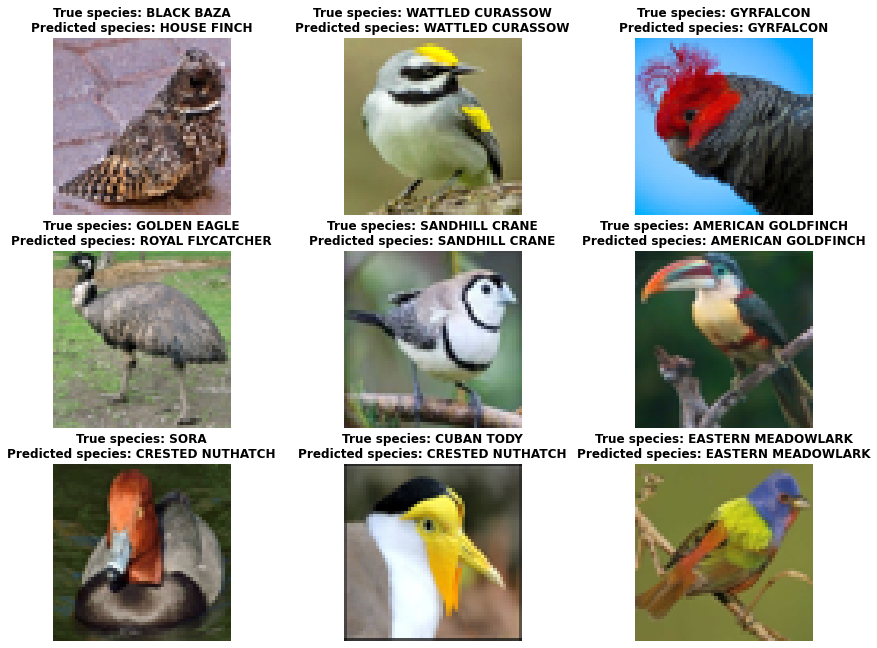

In [27]:
fig = plt.figure(figsize=(20,15))
grid = fig.add_gridspec(4, 4)

for row in range(0, 3):
    for col in range(0, 3):
        num_image = random.randint(0, data_normal["test"].shape[0])
        ax = fig.add_subplot(grid[row, col])
        ax.axis('off');
        ax.set_title("True species: " + str(target["test"][y_true[num_image]] + "\nPredicted species: " + target["test"][y_pred[num_image]]), fontdict={"fontweight": 700})
        ax.imshow(data["test"][num_image]);

In [20]:
datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest')

train_generator = datagen.flow_from_directory('/content/train',
                                               batch_size=64,
                                               target_size=(224,224)
                                             )

validation_generator = datagen.flow_from_directory('/content/valid',
                                                   batch_size=64,
                                                   target_size=(224,224)
                                                  )

Found 47332 images belonging to 325 classes.
Found 1625 images belonging to 325 classes.


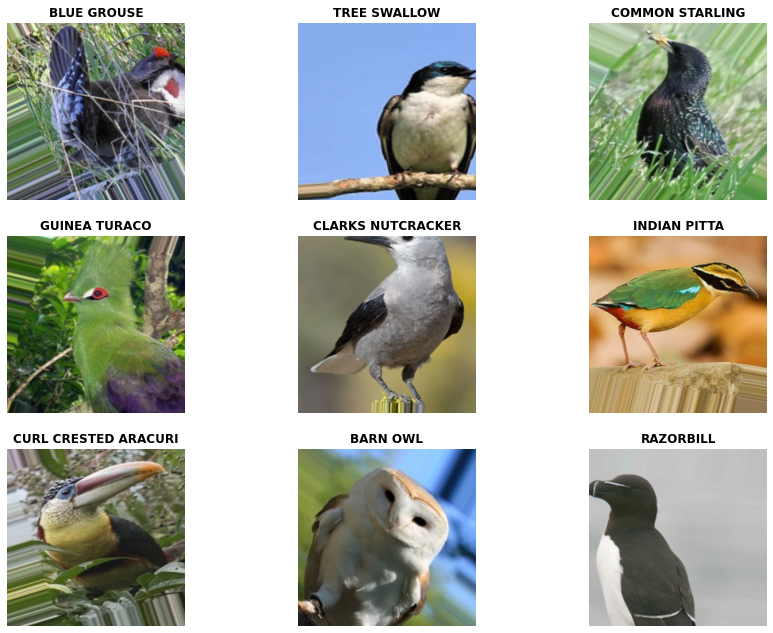

In [24]:
fig = plt.figure(figsize=(20,15))
grid = fig.add_gridspec(4, 4)

for row in range(0, 3):
    for col in range(0, 3):
        image, label = train_generator.next()
        label_id = list(label[0]).index(1)
        label_str = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(label_id)]
        ax = fig.add_subplot(grid[row, col])
        ax.axis('off');
        ax.set_title(label_str, fontdict={"fontweight": 700})
        ax.imshow(image[0]);



In [21]:
from tensorflow.keras import applications
from tensorflow.keras import models

In [41]:
backend.clear_session()

In [42]:
ResNet = tf.keras.applications.ResNet152V2(
         include_top=False,
         weights="imagenet",
         input_shape=(224, 224, 3),
         classifier_activation="softmax",
)

In [43]:
for layer in ResNet.layers[:-10]:
  layer.trainable = False
for layer in ResNet.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f29437b1750> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f27b29cc2d0> False
<keras.layers.convolutional.Conv2D object at 0x7f27b29cc910> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f27a9210e10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f27a9233fd0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f27b29d9110> False
<keras.layers.core.activation.Activation object at 0x7f27a91cfa10> False
<keras.layers.convolutional.Conv2D object at 0x7f2ab00f1710> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f27a921a450> False
<keras.layers.core.activation.Activation object at 0x7f27b29a05d0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f27a9210b90> False
<keras.layers.convolutional.Conv2D object at 0x7f2ab00e89d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f27a92285d0> Fals

In [44]:
flattening_layer = layers.Flatten()
dropout = layers.Dropout(rate=0.4)
norm = layers.BatchNormalization()
last_layer = layers.Dense(325, activation='softmax')

model_ResNet = Sequential([ResNet, flattening_layer, dropout, norm, last_layer])

In [45]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory('/content/train',
    target_size=(224, 224),
    batch_size=64,)

validataion_generator = train_datagen.flow_from_directory('/content/valid',
    target_size=(224, 224),
    batch_size=64,)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('/content/test',
    target_size=(224, 224),
    batch_size=64,)

Found 47332 images belonging to 325 classes.
Found 1625 images belonging to 325 classes.
Found 1625 images belonging to 325 classes.


Epoch 1/20
740/740 [==============================] - 206s 264ms/step - loss: 2.8434 - accuracy: 0.5227 - val_loss: 6.2840 - val_accuracy: 0.5649 - lr: 0.0010
Epoch 2/20
740/740 [==============================] - 192s 259ms/step - loss: 2.0647 - accuracy: 0.6979 - val_loss: 2.9845 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 3/20
740/740 [==============================] - 191s 259ms/step - loss: 1.7338 - accuracy: 0.7573 - val_loss: 1.4489 - val_accuracy: 0.8166 - lr: 0.0010
Epoch 4/20
740/740 [==============================] - 191s 258ms/step - loss: 1.3939 - accuracy: 0.8055 - val_loss: 1.3053 - val_accuracy: 0.8437 - lr: 0.0010
Epoch 5/20
740/740 [==============================] - ETA: 0s - loss: 1.3394 - accuracy: 0.8276
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
740/740 [==============================] - 191s 258ms/step - loss: 1.3394 - accuracy: 0.8276 - val_loss: 1.7590 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 6/20
740/740 [====================

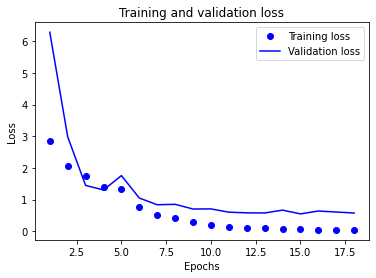

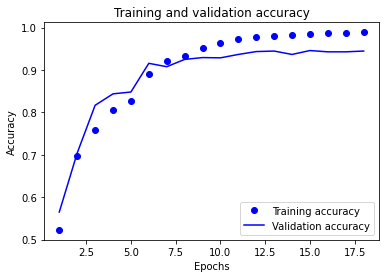

50/50 [==============================] - 6s 120ms/step - loss: 0.4553 - accuracy: 0.9477
test_acc: 0.947692334651947


In [46]:
from tensorflow.keras import backend
backend.clear_session()
model_ResNet.compile(optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])
callback = [EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor=0.5, verbose=1)]

history = model_ResNet.fit(
    train_generator,
    epochs=20,
    validation_data=validataion_generator,
    callbacks = callback)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_accuracy = model_ResNet.evaluate(test_generator, steps = 50)
print('test_acc:', test_accuracy)

In [50]:
test_data_ResNet = train_datagen.flow_from_directory('/content/test',
                                                target_size=(224,224),
                                                batch_size=64)

Found 1625 images belonging to 325 classes.


In [51]:
model_ResNet.evaluate(test_data_ResNet, verbose=1)

26/26 [==============================] - 6s 235ms/step - loss: 0.4926 - accuracy: 0.9483


[0.4925808310508728, 0.9483076930046082]